Mounted at /content/drive


<ipython-input-6-6448276060f6>:123: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal_features = grouped_data.apply(extract_temporal_features).reset_index(drop=True)
<ipython-input-6-6448276060f6>:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_features = grouped_data.apply(mann_kendall_trend).reset_index(drop=True)



Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       0.99      1.00      0.99        68
           2       0.98      0.99      0.98        83
           3       0.94      0.94      0.94        90
           4       0.97      0.98      0.98       113
           5       1.00      1.00      1.00        82
           6       1.00      1.00      1.00        27
           7       0.90      0.94      0.92        94
           8       0.98      0.91      0.94       103
           9       0.98      1.00      0.99        60
          10       1.00      1.00      1.00         9
          11       0.90      0.92      0.91        61
          12       0.98      0.96      0.97       135
          13       1.00      1.00      1.00        71
          14       1.00      0.29      0.45        17
          15       0.76      0.90      0.82        60
          16       0.95      0.94      0.94       118
   

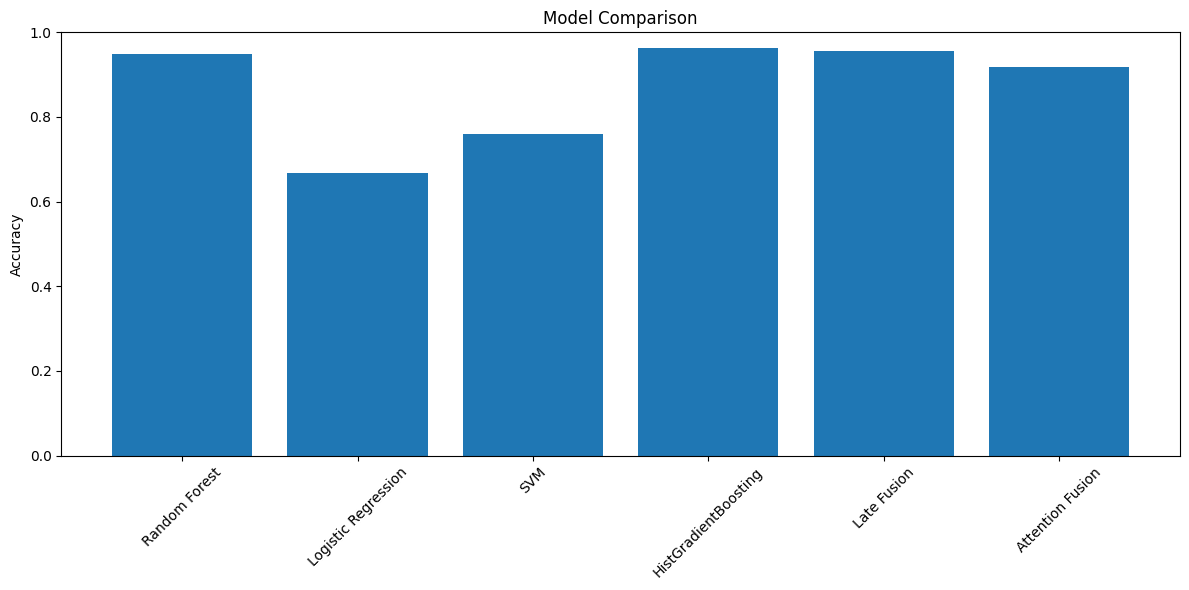

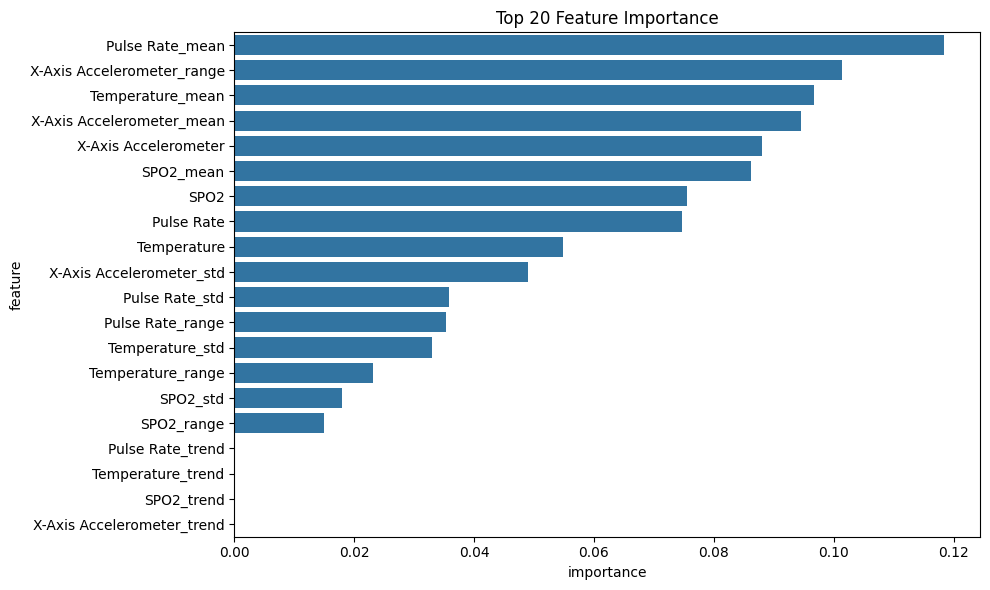

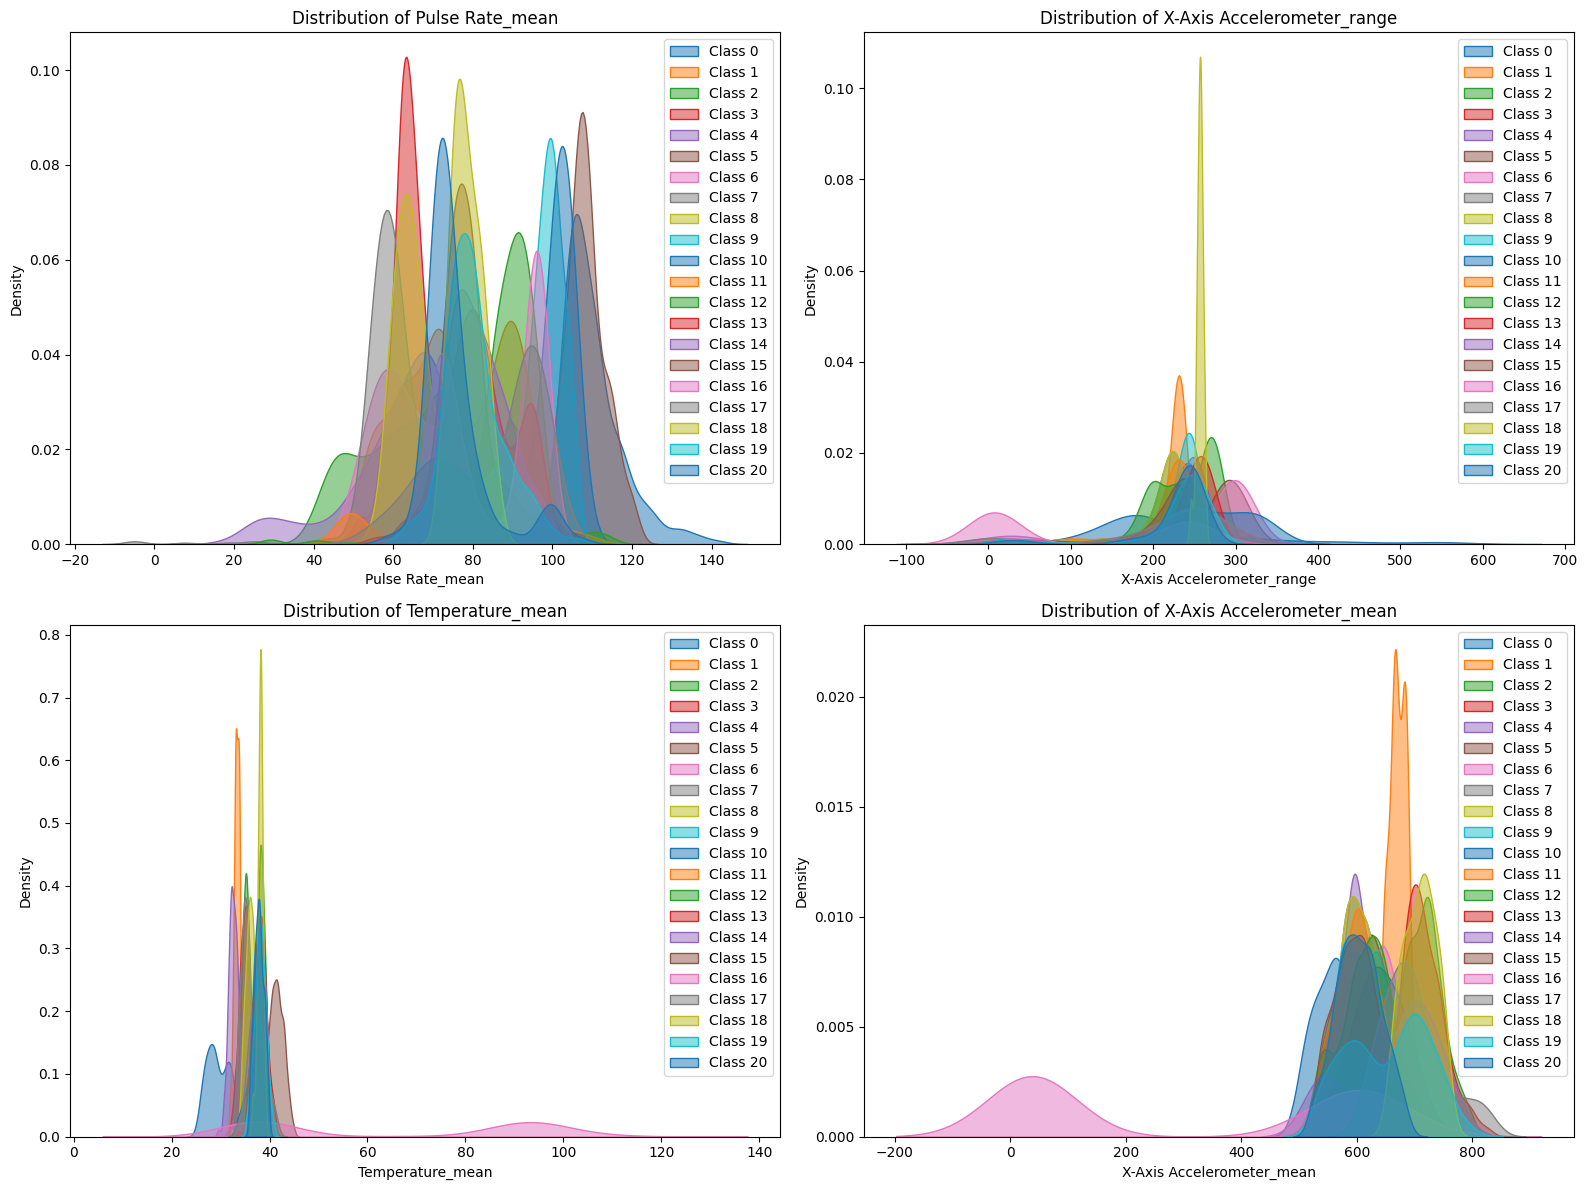

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling1D, Reshape, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
# Constants
DATA_PATH = '/content/drive/MyDrive/Master in IoT and Smart Systems/Thesis/Practical/data/'
RANDOM_STATE = 42

# Data loading and preprocessing
def load_and_preprocess_data(file_prefix, num_files):
    data = []
    for i in range(1, num_files + 1):
        file_path = os.path.join(DATA_PATH, f"{file_prefix}{i}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None,
                             names=['X-Axis Accelerometer', 'Temperature', 'Pulse Rate', 'SPO2', 'Label'])
            df['Subject_ID'] = f"{file_prefix}{i}"
            data.append(df)

    data = pd.concat(data, ignore_index=True)

    # Preprocessing
    numeric_columns = ['X-Axis Accelerometer', 'Temperature', 'Pulse Rate', 'SPO2']

    # Replace 0 with NaN in numeric columns
    data[numeric_columns] = data[numeric_columns].replace(0, np.nan)

    # Fill NaN values with median for each numeric column
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())

    # Use Subject_ID as the label for multi-class classification
    data['Label'] = data['Subject_ID']

    return data

# Feature engineering
def extract_temporal_features(group, window_size=10):
    feature_list = []
    for col in ['X-Axis Accelerometer', 'Temperature', 'Pulse Rate', 'SPO2']:
        rolling = group[col].rolling(window=window_size, min_periods=1)
        features = pd.DataFrame({
            f'{col}_mean': rolling.mean(),
            f'{col}_std': rolling.std(),
            f'{col}_range': rolling.max() - rolling.min()
        })
        feature_list.append(features)
    return pd.concat(feature_list, axis=1)

def mann_kendall_trend(group):
    trends = {}
    for col in ['X-Axis Accelerometer', 'Temperature', 'Pulse Rate', 'SPO2']:
        try:
            trend, _ = stats.kendalltau(group[col], np.arange(len(group)))
            trends[f'{col}_trend'] = trend
        except ValueError:
            trends[f'{col}_trend'] = 0
    return pd.Series(trends)

# Model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=1))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    return accuracy_score(y_test, y_pred)

# Attention fusion model
def attention_fusion_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    reshaped = Reshape((4, -1))(inputs)

    modalities = [Dense(64, activation='relu')(reshaped[:, i, :]) for i in range(4)]
    concat = Concatenate(axis=-1)(modalities)

    attention = Dense(256, activation='softmax')(concat)
    weighted = Multiply()([concat, attention])

    pooled = GlobalAveragePooling1D()(Lambda(lambda x: tf.expand_dims(x, axis=1))(weighted))
    dense = Dense(128, activation='relu')(pooled)
    output = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_feature_distribution(X, y, feature_names):
    classes = np.unique(y)
    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(feature_names):
        plt.subplot(2, 2, i + 1)
        for cls in classes:
            sns.kdeplot(X.loc[y == cls, feature], label=f"Class {cls}", fill=True, alpha=0.5)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    mdd_data = load_and_preprocess_data("D", 9)
    non_mdd_data = load_and_preprocess_data("N", 12)
    data = pd.concat([mdd_data, non_mdd_data], ignore_index=True)

    # Feature engineering
    grouped_data = data.groupby('Subject_ID')
    temporal_features = grouped_data.apply(extract_temporal_features).reset_index(drop=True)
    trend_features = grouped_data.apply(mann_kendall_trend).reset_index(drop=True)

    X = pd.concat([
        data[['X-Axis Accelerometer', 'Temperature', 'Pulse Rate', 'SPO2']].reset_index(drop=True),
        temporal_features,
        trend_features
    ], axis=1).fillna(0)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['Label'])

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        'Logistic Regression': OneVsRestClassifier(LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)),
        'SVM': SVC(random_state=RANDOM_STATE, probability=True, decision_function_shape='ovr'),
        'HistGradientBoosting': HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    }

    accuracies = {}
    for name, model in models.items():
        print(f"\n{name} Results:")
        model.fit(X_train_scaled, y_train)
        accuracies[name] = evaluate_model(model, X_test_scaled, y_test)

    # Late Fusion
    late_fusion_model = VotingClassifier(
        estimators=[(name, model) for name, model in models.items()],
        voting='soft'
    )
    late_fusion_model.fit(X_train_scaled, y_train)
    print("\nLate Fusion Model Results:")
    accuracies['Late Fusion'] = evaluate_model(late_fusion_model, X_test_scaled, y_test)

    # Attention Fusion
    num_classes = len(label_encoder.classes_)
    attention_model = attention_fusion_model(X_train_scaled.shape[1:], num_classes)
    attention_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    attention_accuracy = attention_model.evaluate(X_test_scaled, y_test)[1]
    print(f"\nAttention Fusion Model Accuracy: {attention_accuracy:.4f}")
    accuracies['Attention Fusion'] = attention_accuracy

    # Visualizations
    plt.figure(figsize=(12, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Feature importance
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.show()

    # Feature distribution
    top_features = feature_importance['feature'].head(4).tolist()
    plot_feature_distribution(X, y, top_features)

